<a href="https://colab.research.google.com/github/ary3120-droid/myproject/blob/main/star0205.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##0. 데이터 로드

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from google.colab import drive


drive.mount('/content/drive')

path = '/content/drive/MyDrive/star/'

portfolio = pd.read_json(path + 'portfolio.json', orient='records', lines=True)
profile = pd.read_json(path + 'profile.json', orient='records', lines=True)
transcript = pd.read_json(path + 'transcript.json', orient='records', lines=True)

print("데이터 로딩 성공!")
print(f"Portfolio: {portfolio.shape}, Profile: {profile.shape}, Transcript: {transcript.shape}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
데이터 로딩 성공!
Portfolio: (10, 6), Profile: (17000, 5), Transcript: (306534, 4)


In [17]:
# 1. 한글 폰트 설치 (나눔바른고딕)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 2. 실행 후 [런타임 다시 시작] 을 눌러주세요!

# 3. 런타임 재시작 후 아래 코드로 설정 적용
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

##1. 전처리

In [18]:
# 1. Profile 데이터 정제
# 118세는 결측치이므로 NaN으로 처리
profile['age'] = profile['age'].replace(118, np.nan)

# 가입일자를 날짜 형식으로 변환
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

# 2. Transcript 데이터 정제 (value 컬럼 풀기)
# offer_id, amount, reward를 추출하여 새로운 컬럼 생성
transcript['offer_id'] = transcript['value'].apply(lambda x: x.get('offer_id') or x.get('offer id'))
transcript['amount'] = transcript['value'].apply(lambda x: x.get('amount', 0))
transcript['reward'] = transcript['value'].apply(lambda x: x.get('reward', 0))

# 불필요해진 value 컬럼 삭제
df_log = transcript.drop('value', axis=1)

##2. 서비스 현황 파악 (EDA)

총 매출: $1,775,452
총 고객 수: 17,000명
고객당 평균 결제액: $104.44


/tmp/ipython-input-1187624545.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




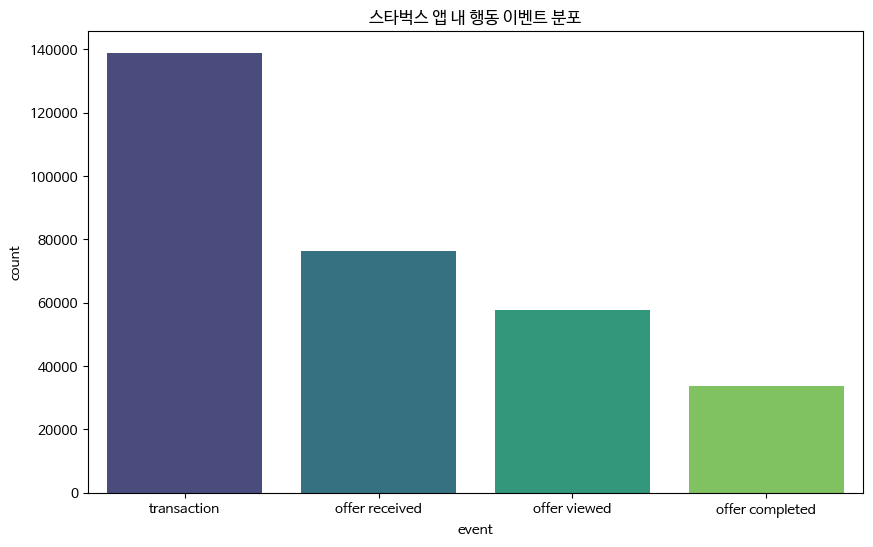

In [19]:
# 1. 주요 지표 요약
total_revenue = df_log['amount'].sum()
unique_users = profile['id'].nunique()
avg_revenue_per_user = total_revenue / unique_users

print(f"총 매출: ${total_revenue:,.0f}")
print(f"총 고객 수: {unique_users:,}명")
print(f"고객당 평균 결제액: ${avg_revenue_per_user:.2f}")

# 2. 이벤트 발생 빈도 시각화
plt.figure(figsize=(10, 6))
sns.countplot(data=df_log, x='event', palette='viridis', order=df_log['event'].value_counts().index)
plt.title('스타벅스 앱 내 행동 이벤트 분포')
plt.show()

##3. 고객 세분화 (RFM + Clustering)

1. RFM 지표 계산 및 점수 부여

먼저 각 고객별로 Recency, Frequency, Monetary 값을 구한 뒤, 이를 1~5점 사이의 점수로 변환

In [20]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 실제 결제(transaction) 데이터만 필터링
df_transactions = df_log[df_log['event'] == 'transaction'].copy()

# 2. RFM 계산을 위한 기준 시점 (데이터의 마지막 시간)
max_time = df_log['time'].max()

# 3. 고객별 RFM 산출
rfm = df_transactions.groupby('person').agg({
    'time': lambda x: max_time - x.max(),  # Recency: 마지막 구매 후 경과 시간 (낮을수록 좋음)
    'event': 'count',                      # Frequency: 구매 횟수 (높을수록 좋음)
    'amount': 'sum'                        # Monetary: 총 구매 금액 (높을수록 좋음)
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']

# 4. 점수 부여 (qcut을 이용해 5등분)
# Recency는 낮을수록 좋은 점수(5점)를 줍니다.
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
# Frequency와 Monetary는 높을수록 좋은 점수(5점)를 줍니다.
# (중복 값이 많을 경우 rank(method='first')를 활용)
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# RFM 총점 계산
rfm['RFM_Score'] = rfm['R_score'].astype(int) + rfm['F_score'].astype(int) + rfm['M_score'].astype(int)

print("RFM 점수 산정 완료")
display(rfm.head())

RFM 점수 산정 완료


,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score
person,,,,,,,
0009655768c64bdeb2e877511632db8f,18,8,127.60,5,3,4,12
00116118485d4dfda04fdbaba9a87b5c,240,3,4.09,1,1,1,3
0011e0d4e6b944f998e987f904e8c1e5,60,5,79.46,3,2,3,8
0020c2b971eb4e9188eac86d93036a77,6,8,196.86,5,3,5,13
0020ccbbb6d84e358d3414a3ff76cffd,42,12,154.05,4,4,4,12


Recency (최근성): 마지막 구매일로부터 경과한 시간입니다. 값이 작을수록 최근에 구매했음을 의미합니다.

Frequency (빈도): 일정 기간 동안의 구매 횟수입니다. 값이 클수록 자주 방문한 고객입니다.

Monetary (금액): 구매한 총 금액입니다. 값이 클수록 매출 기여도가 높은 고객입니다.

Score (R/F/M 점수): 각 지표를 등급화(보통 1~5점)한 것으로, RFM_Score는 이 점수들의 합계입니다.

2. K-Means 군집화 (Clustering)

단순 점수 합계보다 더 정교한 분류를 위해 머신러닝 알고리즘인 K-Means를 적용

In [21]:
# 1. 군집화에 사용할 데이터 준비 (R, F, M 점수 기준)
X = rfm[['R_score', 'F_score', 'M_score']]

# 2. 데이터 표준화 (K-Means는 거리를 기반으로 하므로 스케일링이 중요합니다)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. K-Means 모델 생성 및 학습 (3개 그룹으로 우선 분류)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(X_scaled)

# 4. 군집별 특징 확인
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'RFM_Score': 'mean'
}).reset_index()

print("군집별 평균 지표")
display(cluster_summary)

군집별 평균 지표


,Cluster,Recency,Frequency,Monetary,RFM_Score
0,0,168.564825,4.577790,49.253749,5.491357
1,1,53.229718,12.452607,184.982554,11.940480
2,2,33.612935,6.186918,45.629270,8.641352


3. 결과 시각화

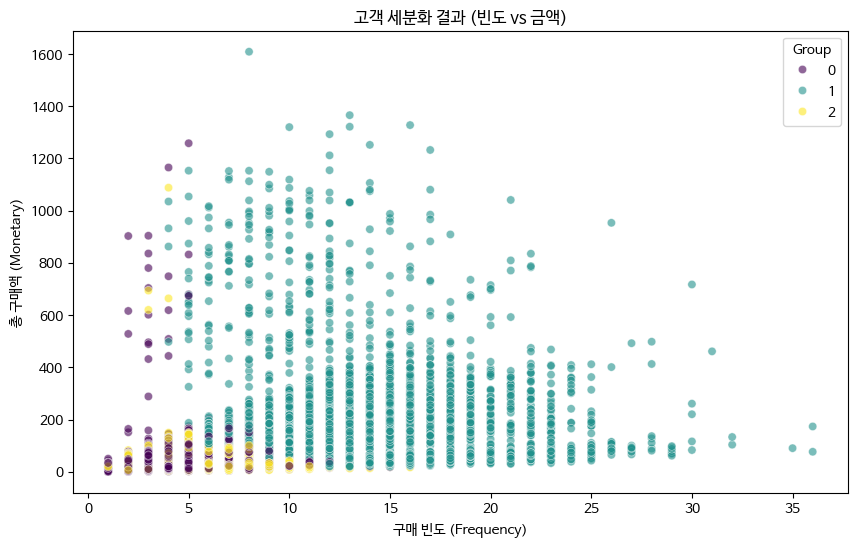

In [22]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Cluster', palette='viridis', alpha=0.6)
plt.title('고객 세분화 결과 (빈도 vs 금액)')
plt.xlabel('구매 빈도 (Frequency)')
plt.ylabel('총 구매액 (Monetary)')
plt.legend(title='Group')
plt.show()

##4. 코호트 & 퍼널 분석 (Flow 중심)

코호트 분석 (가입 월 기준 유지율)

1. 데이터 전처리 및 시간 데이터 정규화

In [23]:
# 1-1. 시간 데이터 변환
# 데이터의 실제 운영 기간을 반영하여 기준일 설정
base_date = pd.Timestamp('2018-01-01')
df_log['date'] = base_date + pd.to_timedelta(df_log['time'], unit='h')
df_log['OrderMonth'] = df_log['date'].dt.to_period('M')

# 1-2. 고객 가입 정보 결합
# 프로필 데이터의 가입일을 활동 로그(df_log)에 병합
df_log = pd.merge(df_log, profile[['id', 'became_member_on']], left_on='person', right_on='id', how='left')
df_log['CohortMonth'] = df_log['became_member_on'].dt.to_period('M')

# 1-3. 경과 주차(CohortIndex) 계산 (1주일 = 168시간)
df_log['CohortIndex_Week'] = (df_log['time'] // 168).astype(int) + 1

print("전처리 수정 완료!")

전처리 수정 완료!


2. 코호트 분석 및 가독성 개선 시각화

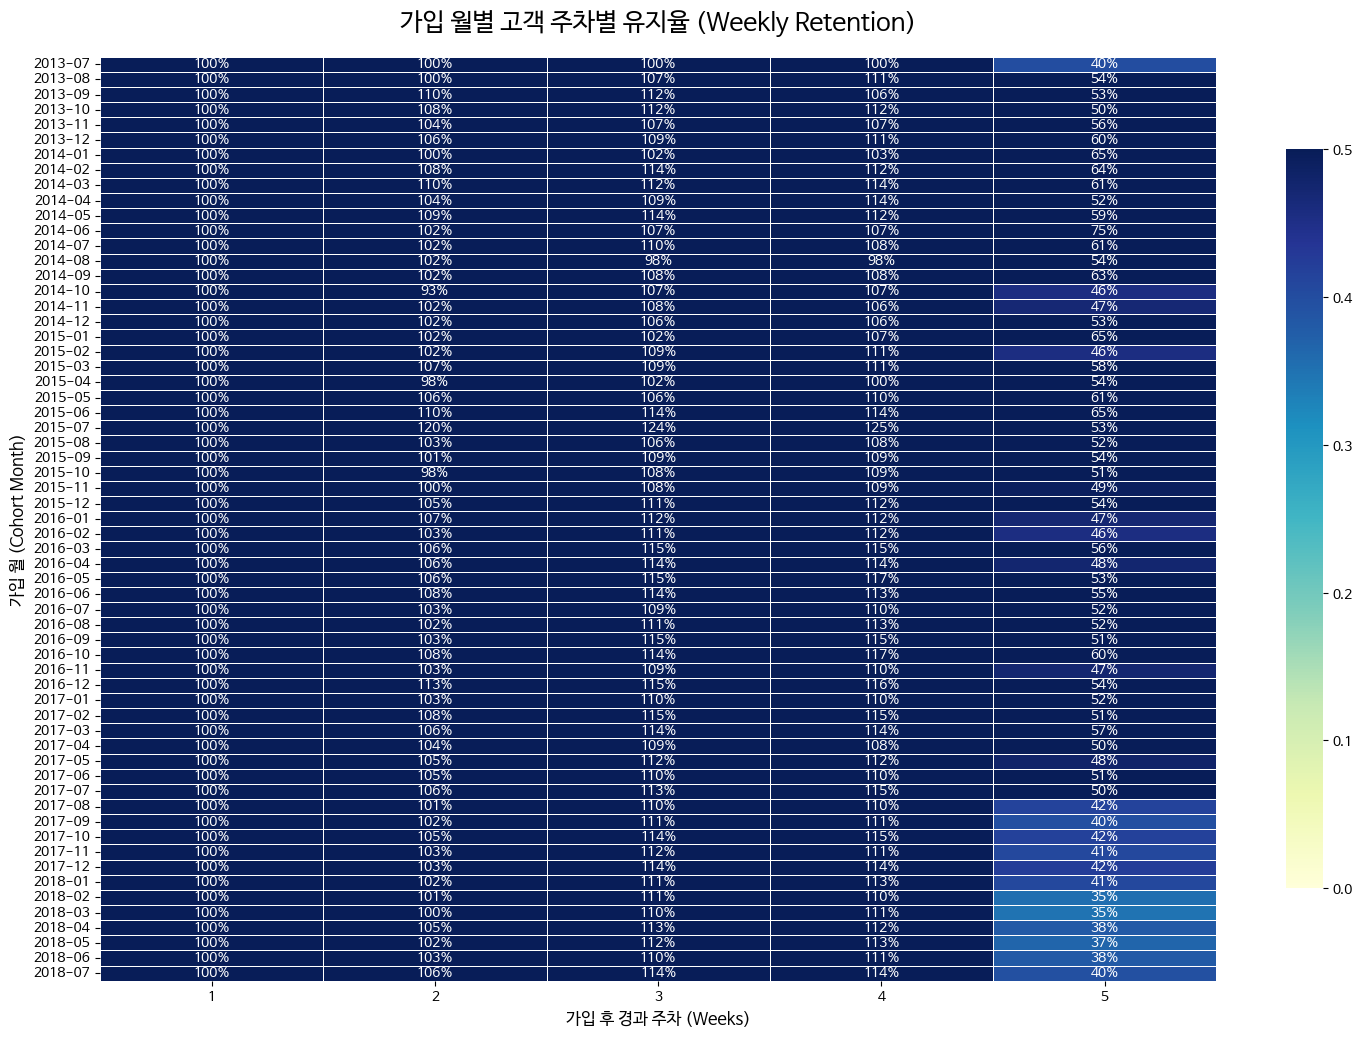

In [26]:
# 2-1. 코호트 매트릭스 및 리텐션 계산
cohort_data_week = df_log.groupby(['CohortMonth', 'CohortIndex_Week'])['person'].nunique().reset_index()
cohort_pivot_week = cohort_data_week.pivot(index='CohortMonth', columns='CohortIndex_Week', values='person')

# 첫 주차 인원을 기준으로 유지율 산출
retention_week = cohort_pivot_week.divide(cohort_pivot_week.iloc[:, 0], axis=0)

# 2-2. 시각화 가독성 개선
plt.figure(figsize=(18, 12))
plt.title('가입 월별 고객 주차별 유지율 (Weekly Retention)', fontsize=18, pad=20)

# fmt='.0%'로 소수점 제거, cbar_kws로 컬러바 크기 조절
sns.heatmap(retention_week,
            annot=True,
            fmt='.0%',
            cmap='YlGnBu',
            vmin=0, vmax=0.5,
            linewidths=.5,
            cbar_kws={"shrink": .8})

plt.xlabel('가입 후 경과 주차 (Weeks)', fontsize=12)
plt.ylabel('가입 월 (Cohort Month)', fontsize=12)
plt.xticks(rotation=0)
plt.show()

3. 인터랙티브 퍼널 분석 시각화

In [27]:
import plotly.graph_objects as go

# 3-1. 이벤트 단계별 고유 사용자 수 집계
steps = ['offer received', 'offer viewed', 'offer completed']
counts = [df_log[df_log['event'] == s]['person'].nunique() for s in steps]

# 3-2. 세련된 퍼널 차트 구성
fig = go.Figure(go.Funnel(
    y = ['제안 수령 (Received)', '제안 확인 (Viewed)', '제안 완료 (Completed)'],
    x = counts,
    textinfo = "value+percent initial+percent previous", # 이전 단계 및 전체 대비 비율 표시
    marker = {"color": ["#d1e5f0", "#67a9cf", "#2166ac"],
              "line": {"width": [2, 2, 2], "color": ["white", "white", "white"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}}
))

fig.update_layout(
    title={'text': "마케팅 퍼널 단계별 전환율 분석", 'x':0.5, 'xanchor': 'center'},
    font=dict(size=14),
    showlegend=False
)

fig.show()

In [28]:
import plotly.graph_objects as go

# 1. 고유 사용자 수 집계 (실무형 4단계)
received = df_log[df_log['event'] == 'offer received']['person'].nunique()
viewed = df_log[df_log['event'] == 'offer viewed']['person'].nunique()
# 실제 돈을 쓴 Transaction 단계 추가
transaction = df_log[df_log['event'] == 'transaction']['person'].nunique()
completed = df_log[df_log['event'] == 'offer completed']['person'].nunique()

# 2. 퍼널 시각화 (가독성 개선 버전)
fig = go.Figure(go.Funnel(
    y = ['1. 쿠폰 수령 (Received)', '2. 쿠폰 조회 (Viewed)', '3. 실제 결제 (Transaction)', '4. 미션 완료 (Completed)'],
    x = [received, viewed, transaction, completed],
    textinfo = "value+percent initial+percent previous",
    marker = {"color": ["#DAE8FC", "#B1C9ED", "#6C8EBF", "#284E8A"]}
))

fig.update_layout(title_text='스타벅스 마케팅-매출 통합 퍼널 분석', title_x=0.5)
fig.show()

4. 실무 중심의 Flow 분석 (고도화 버전)

기존 분석에 실제 매출을 일으키는 결제(Transaction) 단계를 추가하고, 마케팅의 실질적 영향력을 보기 위해 기준점을 변경한다.

(1) 실무형 코호트: 첫 쿠폰 수령 기준 결제 유지율
가입일이 아닌 쿠폰을 처음 받은 시점을 기준으로 고객의 결제 지속성을 추적한다.

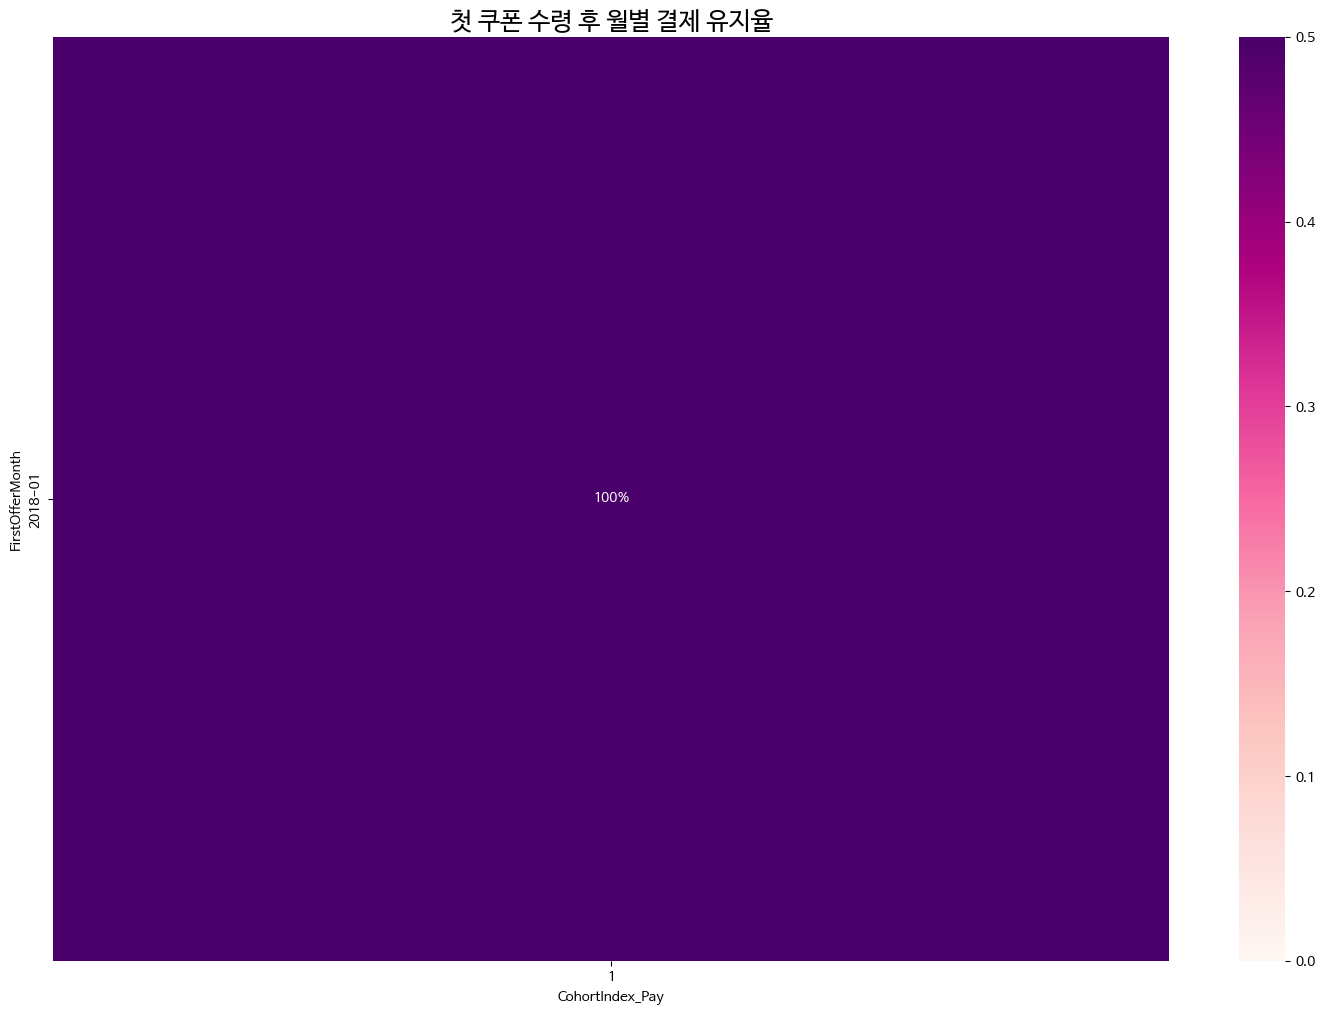

In [29]:
# 1-1. 고객별 첫 쿠폰 수령 월 계산
first_offer = df_log[df_log['event'] == 'offer received'].groupby('person')['date'].min().reset_index()
first_offer.columns = ['person', 'FirstOfferDate']
first_offer['FirstOfferMonth'] = first_offer['FirstOfferDate'].dt.to_period('M')

# 1-2. 데이터 병합 및 쿠폰 기준 인덱스 생성
df_log_offer = pd.merge(df_log, first_offer[['person', 'FirstOfferMonth']], on='person', how='left')

# 결제(transaction) 데이터만 필터링하여 리텐션 계산
df_pay_only = df_log_offer[df_log_offer['event'] == 'transaction'].copy()
df_pay_only['CohortIndex_Pay'] = get_month_diff(df_pay_only, 'OrderMonth', 'FirstOfferMonth')

# 1-3. 매트릭스 생성 및 시각화
pay_cohort = df_pay_only.groupby(['FirstOfferMonth', 'CohortIndex_Pay'])['person'].nunique().reset_index()
pay_pivot = pay_cohort.pivot(index='FirstOfferMonth', columns='CohortIndex_Pay', values='person')
pay_retention = pay_pivot.divide(pay_pivot.iloc[:, 0], axis=0)

plt.figure(figsize=(18, 12))
plt.title('첫 쿠폰 수령 후 월별 결제 유지율', fontsize=18)
sns.heatmap(pay_retention, annot=True, fmt='.0%', cmap='RdPu', vmin=0, vmax=0.5)
plt.show()

In [ ]:
(2) 고도화된 퍼널: 마케팅-매출 통합 여정
제안 확인(Viewed)과 완료(Completed) 사이에 실제 결제(Transaction) 단계를 넣어 이탈 구간을 분석한다.

In [30]:
import plotly.graph_objects as go

# 2-1. 4단계 고유 사용자 수 집계
# 수령 -> 조회 -> 실제 결제 -> 보상 완료
received = df_log[df_log['event'] == 'offer received']['person'].nunique()
viewed = df_log[df_log['event'] == 'offer viewed']['person'].nunique()
transaction = df_log[df_log['event'] == 'transaction']['person'].nunique()
completed = df_log[df_log['event'] == 'offer completed']['person'].nunique()

# 2-2. 통합 퍼널 시각화
fig = go.Figure(go.Funnel(
    y = ['1. 쿠폰 수령 (Received)', '2. 쿠폰 조회 (Viewed)', '3. 실제 결제 (Transaction)', '4. 미션 완료 (Completed)'],
    x = [received, viewed, transaction, completed],
    textinfo = "value+percent initial+percent previous",
    marker = {"color": ["#DAE8FC", "#B1C9ED", "#6C8EBF", "#284E8A"]}
))

fig.update_layout(title_text='스타벅스 마케팅-매출 통합 퍼널 분석', title_x=0.5)
fig.show()